In [36]:
# Cell 1: Imports and experiment configuration

import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import graphical_lasso, ledoit_wolf  # <- add ledoit_wolf

import matplotlib.pyplot as plt

# If you want to also have your external script available:
# import calculate_glasso

# Experiment configuration
TICKERS = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'SPY', 'QQQ', 'GLD']  # or your full universe
START_DATE = "2023-01-01"
END_DATE = "2024-01-01"

ALPHA = 0.4                      # Graphical Lasso regularization parameter
WINDOW_WEEKS = 2
TRADING_DAYS_PER_WEEK = 5
WINDOW_SIZE = WINDOW_WEEKS * TRADING_DAYS_PER_WEEK  # approx 10 trading days

print("Config loaded.")
print("  n_tickers:", len(TICKERS))
print("  date range:", START_DATE, "->", END_DATE)
print("  WINDOW_SIZE (trading days):", WINDOW_SIZE)


Config loaded.
  n_tickers: 8
  date range: 2023-01-01 -> 2024-01-01
  WINDOW_SIZE (trading days): 10


In [37]:
# Cell 2: Data retrieval and returns computation

def get_data(tickers, start_date, end_date):
    """
    Download adjusted close prices from Yahoo Finance and compute daily returns.
    """
    print("Downloading data from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    
    # Make sure we always have a DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()
    
    # Calculate returns and drop days with any missing values across tickers
    returns = data.pct_change().dropna(how="any")
    print(f"✅ Retrieved {returns.shape[1]} assets over {returns.shape[0]} days")
    return returns

# Retrieve 1-year daily returns
returns_df = get_data(TICKERS, START_DATE, END_DATE)

print("\nreturns_df info:")
print("  shape:", returns_df.shape)
print("  columns (tickers):", list(returns_df.columns))
print(returns_df.head())


C:\Users\nicco\AppData\Local\Temp\ipykernel_35064\745956638.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[**********************75%***********            ]  6 of 8 completed

[*********************100%***********************]  8 of 8 completed

✅ Retrieved 8 assets over 249 days

returns_df info:
  shape: (249, 8)
  columns (tickers): ['AAPL', 'AMZN', 'GLD', 'GOOG', 'MSFT', 'QQQ', 'SPY', 'TSLA']
Ticker          AAPL      AMZN       GLD      GOOG      MSFT       QQQ  \
Date                                                                     
2023-01-04  0.010314 -0.007924  0.009412 -0.011037 -0.043743  0.004764   
2023-01-05 -0.010605 -0.023726 -0.012451 -0.021869 -0.029638 -0.015654   
2023-01-06  0.036794  0.035611  0.018707  0.016019  0.011785  0.027601   
2023-01-09  0.004089  0.014870  0.002245  0.007260  0.009736  0.006473   
2023-01-10  0.004457  0.028732  0.003676  0.004955  0.007617  0.008464   

Ticker           SPY      TSLA  
Date                            
2023-01-04  0.007720  0.051249  
2023-01-05 -0.011413 -0.029039  
2023-01-06  0.022932  0.024651  
2023-01-09 -0.000567  0.059349  
2023-01-10  0.007013 -0.007681  


In [38]:
# Cell 3: Split the returns into fixed 2-week windows

def split_into_windows(returns_df, window_size):
    """
    Split the returns DataFrame into non-overlapping windows
    of length `window_size` along the time axis.
    """
    n_samples = returns_df.shape[0]
    n_windows = n_samples // window_size  # floor division

    windows = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        win = returns_df.iloc[start:end]
        windows.append(win)
    return windows

windows = split_into_windows(returns_df, WINDOW_SIZE)

print("Number of windows:", len(windows))
if len(windows) > 0:
    print("First window shape:", windows[0].shape)
    print("First window date range:", windows[0].index[0].date(), "->", windows[0].index[-1].date())
    print("Last window date range:", windows[-1].index[0].date(), "->", windows[-1].index[-1].date())


Number of windows: 24
First window shape: (10, 8)
First window date range: 2023-01-04 -> 2023-01-18
Last window date range: 2023-12-04 -> 2023-12-15


In [47]:
# Cell 4: Covariance and precision estimation per window (sample and Glasso)
# Adds a condition-number check before attempting to invert the sample covariance.


def compute_cov_prec_for_window(window_returns, alpha):
    """
    Given a returns window (T x N), standardize it, then:
    - compute the sample covariance of standardized data
    - compute the inverse (precision) of the sample covariance, but only if it is
      sufficiently well-conditioned (based on the condition number)
    - compute a Ledoit–Wolf covariance for input to Graphical Lasso
    - apply Graphical Lasso to obtain a regularized covariance + precision

    Returns
    -------
    sample_cov : (N, N) ndarray
        Sample covariance matrix of standardized returns.
    sample_prec : (N, N) ndarray or None
        Inverse (precision) of sample_cov. Uses pseudo-inverse if poorly conditioned,
        or None if even pseudo-inverse fails.
    glasso_cov : (N, N) ndarray
        Covariance matrix estimated by Graphical Lasso.
    glasso_prec : (N, N) ndarray
        Precision matrix estimated by Graphical Lasso.
    """
    # --- STANDARDIZE RETURNS IN THE WINDOW ---
    scaler = StandardScaler()
    X = scaler.fit_transform(window_returns.values)  # shape: (T, N)

    # --- UNREGULARIZED SAMPLE COVARIANCE ---
    sample_cov = np.cov(X, rowvar=False)  # shape: (N, N)

    # --- CONDITION NUMBER CHECK ---
    try:
        cond_sample = np.linalg.cond(sample_cov) # 2-norm, computed directly using the SVD
    except np.linalg.LinAlgError as e:
        print(
            "Warning: could not compute condition number for sample covariance "
            f"in this window. Treating it as ill-conditioned.\n  Details: {e}"
        )
        cond_sample = np.inf
    

    sample_prec = None
    is_well_conditioned = np.isfinite(cond_sample) and cond_sample < MAX_CONDITION_NUMBER

    if is_well_conditioned:
        # Reasonably conditioned → try standard inverse first
        try:
            sample_prec = np.linalg.inv(sample_cov)
        except np.linalg.LinAlgError as e:
            print(
                "Warning: sample covariance appears well-conditioned "
                f"(cond={cond_sample:.2e}) but inversion failed;\n"
                f"  Details: {e}"
            )
            sample_prec = None
    else:
        # Poorly conditioned → do not attempt direct inverse, go straight to pseudo-inverse
        print(
            "Warning: sample covariance is poorly conditioned in this window "
            f"(cond={cond_sample:.2e}); using pseudo-inverse instead of direct inverse."
        )
        sample_prec = None

    # --- LEDOIT–WOLF COVARIANCE FOR GLASSO INPUT ---
    # We use standardized data and assume it is centered.
    emp_cov, _ = ledoit_wolf(X, assume_centered=True)

    # --- GRAPHICAL LASSO ---
    glasso_cov, glasso_prec = graphical_lasso(emp_cov, alpha=alpha, tol=1e-4)
    
    cond_glasso = np.linalg.cond(glasso_cov)
    
    print(f"Sample Var. conditioning: {cond_sample}\n Glasso Var. conditioning: {cond_glasso}")

    return sample_cov, sample_prec, glasso_cov, glasso_prec


# Run estimation on all windows
sample_covs = []
sample_precs = []   # list of sample precision matrices (or None)
glasso_covs = []
glasso_precs = []   # list of Glasso precision matrices

for idx, win in enumerate(windows):
    s_cov, s_prec, g_cov, g_prec = compute_cov_prec_for_window(win, ALPHA)
    sample_covs.append(s_cov)
    sample_precs.append(s_prec)
    glasso_covs.append(g_cov)
    glasso_precs.append(g_prec)

print("Covariance and precision matrices computed.")
print("  number of windows:", len(sample_covs))
if len(sample_covs) > 0:
    print("  covariance matrix shape:", sample_covs[0].shape)


Sample Var. conditioning: 4501.19749590785
 Glasso Var. conditioning: 2.272840801519336
Sample Var. conditioning: 388.3269455273787
 Glasso Var. conditioning: 3.2282638171916807
Sample Var. conditioning: 7055.356549963027
 Glasso Var. conditioning: 1.9323834464763787
Sample Var. conditioning: 2164.1876618145875
 Glasso Var. conditioning: 3.748126235624759
Sample Var. conditioning: 1955.4983931770448
 Glasso Var. conditioning: 4.5944017442053555
Sample Var. conditioning: 5375.161464280746
 Glasso Var. conditioning: 2.1646622000138303
Sample Var. conditioning: 17184.0279152267
 Glasso Var. conditioning: 2.386926759017036
Sample Var. conditioning: 3102.1566683805486
 Glasso Var. conditioning: 1.0
Sample Var. conditioning: 538.9721380866798
 Glasso Var. conditioning: 1.1635434598741132
Sample Var. conditioning: 572.9267435345489
 Glasso Var. conditioning: 1.7841564269916161
Sample Var. conditioning: 582.3838904571292
 Glasso Var. conditioning: 1.4771596521154156
Sample Var. conditioning: 6

In [40]:
# Cell 5: Frobenius norm differences across consecutive windows

def frobenius_differences(cov_list):
    """
    Compute Frobenius norm of differences between consecutive
    covariance matrices in `cov_list`.
    """
    diffs = []
    for i in range(len(cov_list) - 1):
        delta = cov_list[i+1] - cov_list[i]
        frob = np.linalg.norm(delta, ord='fro')
        diffs.append(frob)
    return np.array(diffs)

fro_sample = frobenius_differences(sample_covs)
fro_glasso = frobenius_differences(glasso_covs)

# Build a DataFrame for easier inspection
window_pairs = []
for i in range(len(windows) - 1):
    w1 = windows[i]
    w2 = windows[i+1]
    label = f"{w1.index[0].date()}–{w1.index[-1].date()} -> {w2.index[0].date()}–{w2.index[-1].date()}"
    window_pairs.append(label)

results_df = pd.DataFrame({
    "window_pair": window_pairs,
    "frobenius_sample": fro_sample,
    "frobenius_glasso": fro_glasso,
})

print("Frobenius differences between consecutive windows:")
print(results_df.head())
print("\nSummary statistics:")
print("  mean(sample) :", results_df["frobenius_sample"].mean())
print("  mean(glasso) :", results_df["frobenius_glasso"].mean())
print("  std(sample)  :", results_df["frobenius_sample"].std())
print("  std(glasso)  :", results_df["frobenius_glasso"].std())


Frobenius differences between consecutive windows:
                                      window_pair  frobenius_sample  \
0  2023-01-04–2023-01-18 -> 2023-01-19–2023-02-01          3.811826   
1  2023-01-19–2023-02-01 -> 2023-02-02–2023-02-15          3.192727   
2  2023-02-02–2023-02-15 -> 2023-02-16–2023-03-02          3.085270   
3  2023-02-16–2023-03-02 -> 2023-03-03–2023-03-16          2.064077   
4  2023-03-03–2023-03-16 -> 2023-03-17–2023-03-30          3.061501   

   frobenius_glasso  
0          0.924681  
1          0.873548  
2          1.005826  
3          0.782781  
4          1.438877  

Summary statistics:
  mean(sample) : 2.806219104681228
  mean(glasso) : 0.7144565411506523
  std(sample)  : 0.6330528460300922
  std(glasso)  : 0.38619662794350573


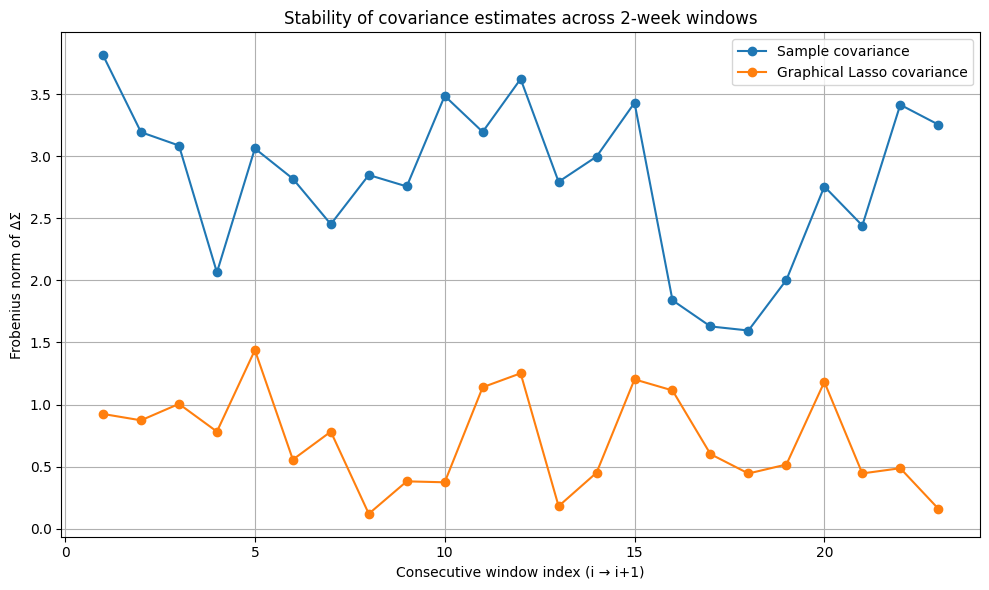

Stability comparison plot generated.


In [41]:
# Cell 6: Plot sample vs Glasso Frobenius norms

plt.figure(figsize=(10, 6))
x = np.arange(1, len(fro_sample) + 1)

plt.plot(x, fro_sample, marker='o', label="Sample covariance")
plt.plot(x, fro_glasso, marker='o', label="Graphical Lasso covariance")

plt.xlabel("Consecutive window index (i → i+1)")
plt.ylabel("Frobenius norm of ΔΣ")
plt.title("Stability of covariance estimates across 2-week windows")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Stability comparison plot generated.")


Frobenius differences between consecutive windows (PRECISION matrices):
  window_pair  frobenius_sample_prec  frobenius_glasso_prec
0         0→1             746.441218               0.772829
1         1→2            1254.943703               0.665251
2         2→3            1105.894414               0.772776
3         3→4             211.293164               0.680728
4         4→5             961.542909               1.044596

Summary statistics for precision matrices:
  mean(sample precision) : 1272.0275211319988
  mean(glasso precision) : 0.5998139988824092
  std(sample precision)  : 1610.5653782609495
  std(glasso precision)  : 0.27791640144015517


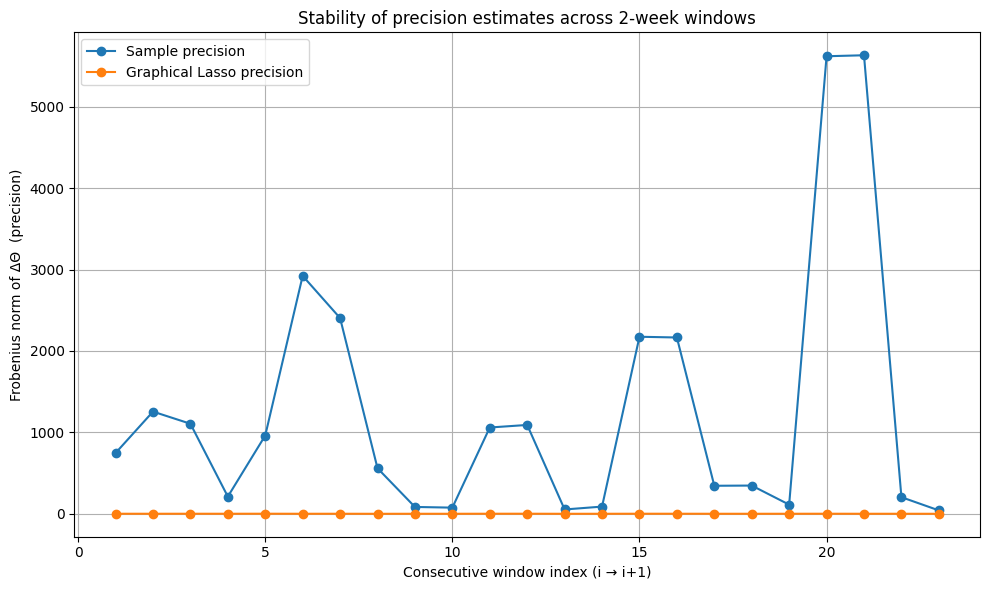

Precision stability comparison plot generated.
[ 746.44121841 1254.94370272 1105.8944142   211.29316361  961.54290922
 2921.97705132 2403.76650056  559.29102213   84.15589222   75.69867754
 1059.80834906 1091.12759644   53.18928819   88.48967345 2174.21681804
 2165.17272365  344.31098006  346.8470582   112.41103945 5618.91847458
 5631.05646356  204.14289698   41.93707245]
[0.77282889 0.66525093 0.7727762  0.68072813 1.04459621 0.51304967
 0.66634577 0.11653211 0.35747147 0.33508027 0.95233848 1.00719572
 0.18497345 0.39974408 0.92778386 0.85693258 0.52030579 0.42680317
 0.56112537 0.94036243 0.44963688 0.47947543 0.1643851 ]


In [42]:
# Cell 7: Frobenius norm differences for precision matrices (sample vs Glasso)

# Reuse the same helper; it works for any list of matrices (covariances or precisions)
fro_sample_prec = frobenius_differences(sample_precs)
fro_glasso_prec = frobenius_differences(glasso_precs)

# Label window pairs i -> i+1
window_pairs_prec = [f"{i}→{i+1}" for i in range(len(fro_sample_prec))]

prec_results_df = pd.DataFrame({
    "window_pair": window_pairs_prec,
    "frobenius_sample_prec": fro_sample_prec,
    "frobenius_glasso_prec": fro_glasso_prec,
})

print("Frobenius differences between consecutive windows (PRECISION matrices):")
print(prec_results_df.head())

print("\nSummary statistics for precision matrices:")
print("  mean(sample precision) :", prec_results_df["frobenius_sample_prec"].mean())
print("  mean(glasso precision) :", prec_results_df["frobenius_glasso_prec"].mean())
print("  std(sample precision)  :", prec_results_df["frobenius_sample_prec"].std())
print("  std(glasso precision)  :", prec_results_df["frobenius_glasso_prec"].std())

# Plot the stability over window pairs
plt.figure(figsize=(10, 6))
x = np.arange(1, len(fro_sample_prec) + 1)

plt.plot(x, fro_sample_prec, marker='o', label="Sample precision")
plt.plot(x, fro_glasso_prec, marker='o', label="Graphical Lasso precision")

plt.xlabel("Consecutive window index (i → i+1)")
plt.ylabel("Frobenius norm of ΔΘ  (precision)")
plt.title("Stability of precision estimates across 2-week windows")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Precision stability comparison plot generated.")


print(fro_sample_prec)
print(fro_glasso_prec)
